# Supplementary Plots


**Last Modified**: Aug 11, 2025


In [1]:
# System & OS

import sys
import os
import time
import warnings
import random
import psutil
sys.path.append('../')
sys.path.append('../../')

import numpy as np
import pandas as pd
from tqdm import tqdm

# Torch
import torch
from torch.utils.data import TensorDataset, DataLoader

# Script imports
from src.utils.io import (get_results_path,
                            get_figures_dir,
                            get_matched_data_path,
                            get_online_pred_path)

from src.utils.plot import(multi_label_predictions)

from src.utils.data import (setup_data_objects,
                            setup_multilabel_dataloaders,
                            get_exp_filter_profiles,
                            adjust_behavior_and_durations)

from src.utils.conformal import validate

from config.settings import (COLLAPSE_BEHAVIORS_MAPPING,
                             BEHAVIORS,
                             SAMPLING_RATE,
                             VECTRONICS_METADATA_PATH,
                             AWD_VECTRONICS_PATHS,
                             id_mapping)

from src.data_prep.data_prep_utils import combined_annotations

# Plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.calibration import calibration_curve

device = torch.device(f"cuda:0" if torch.cuda.is_available() else "cpu")

In [2]:
# Graphing Parameters
import matplotlib as mpl
mpl.rcParams['lines.markersize'] = 12
mpl.rcParams['lines.linewidth'] = 2
mpl.rcParams['xtick.labelsize'] = 25
mpl.rcParams['ytick.labelsize'] = 25
mpl.rcParams["axes.labelsize"] = 25
mpl.rcParams['legend.fontsize'] = 25
mpl.rcParams['axes.titlesize'] = 25
mpl.rcParams['text.usetex'] = True
# plt.rcParams['font.family'] = 'serif'

In [3]:
label_encoder = LabelEncoder()
label_encoder.fit(BEHAVIORS)

LabelEncoder()

In [6]:
acc_data = pd.read_csv(get_matched_data_path())
acc_data = adjust_behavior_and_durations(acc_data, COLLAPSE_BEHAVIORS_MAPPING, BEHAVIORS)

duration_percentiles = [20, 30, 40, 50, 60, 70, 80]
durations = [np.percentile(acc_data['duration'].values, d) for d in duration_percentiles]

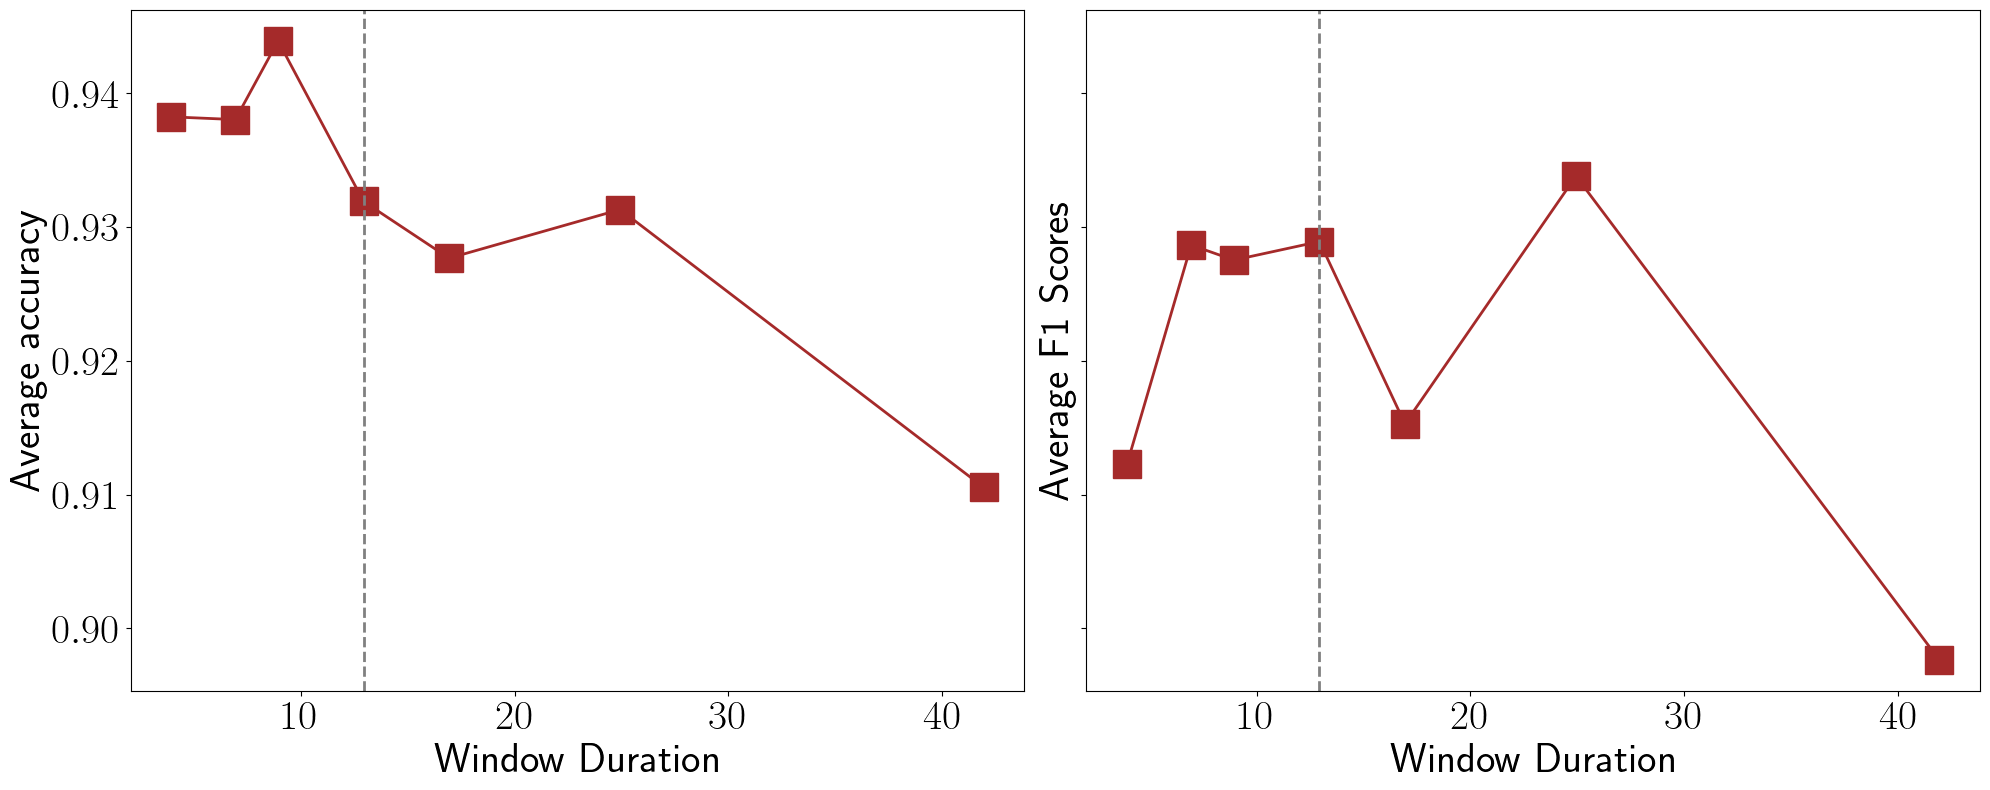

In [10]:
accuracies, f1_scores = np.zeros(len(duration_percentiles)), np.zeros(len(duration_percentiles))

for i,d in enumerate(duration_percentiles):
    dir = get_results_path('no_split', 5, 32, 5, 0.9, d)
    accuracies[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_accuracy=True)
    f1_scores[i] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

fig, axs = plt.subplots(1,2, figsize=(20,8), sharey=True)

axs[0].plot(durations, accuracies, markersize=20, marker='s', color='brown')
axs[0].set_ylabel('Average accuracy')
axs[0].set_xlabel('Window Duration')
axs[0].axvline(x = durations[3], linestyle='--', color='grey')

axs[1].plot(durations, f1_scores, markersize=20, marker='s', color='brown')
axs[1].set_ylabel('Average F1 Scores')
axs[1].set_xlabel('Window Duration')
axs[1].axvline(x = durations[3], linestyle='--', color='grey')

plt.tight_layout()
plt.show()

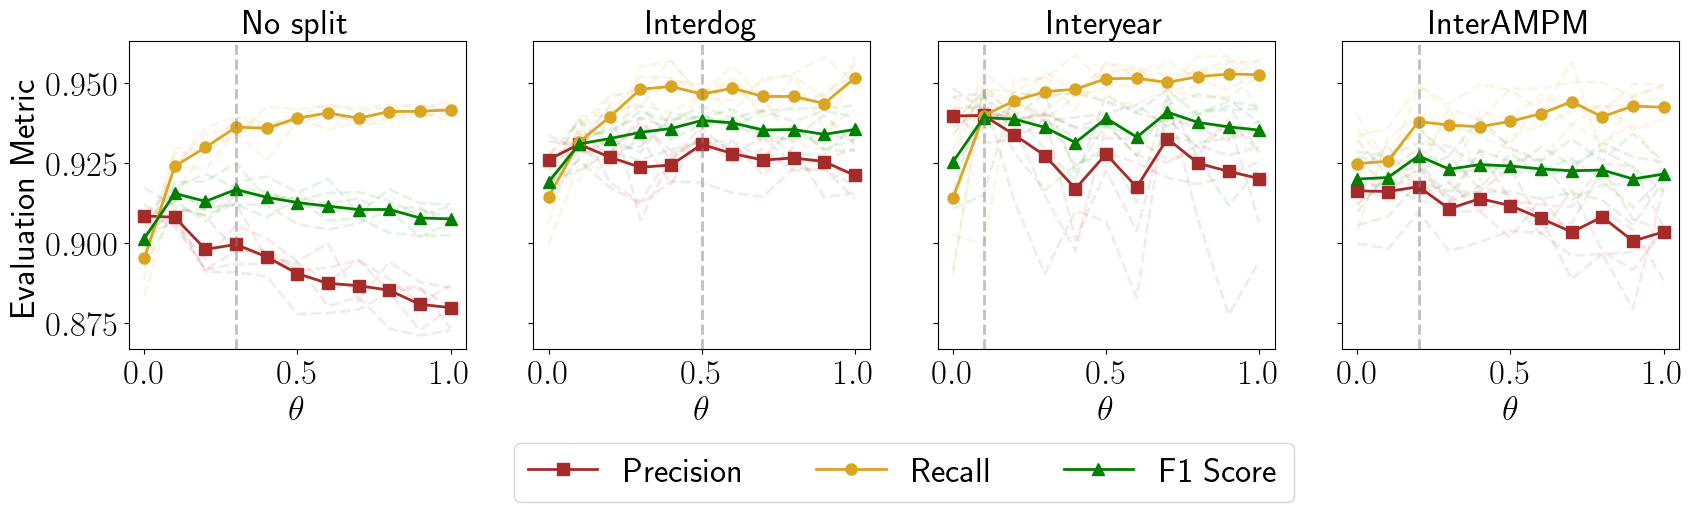

In [6]:
thetas = 0.1*np.arange(11)
colors = ['brown', 'goldenrod', 'green']
experiments = ['no_split', 'interdog', 'interyear', 'interAMPM']
experiment_names = ['No split', 'Interdog', 'Interyear', 'InterAMPM']
layers = [3, 5, 5, 5]
chosen_theta = [0.3, 0.5, 0.1, 0.2]
fig, axs = plt.subplots(1, 4, figsize=(20,4), sharey=True)
seeds = [0, 1, 2, 3, 4, 5]

for (e, exp) in enumerate(experiments):
    precisions = np.zeros((len(thetas), len(seeds)))
    recalls = np.zeros((len(thetas), len(seeds)))
    f1scores = np.zeros((len(thetas), len(seeds)))

    for i, theta in enumerate(thetas):
        for j, seed in enumerate(seeds):
            dir = get_results_path(exp, layers[e], 64, 5, np.round(theta,1), seed)
            precisions[i, j] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_precision=True)
            recalls[i, j] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_recall=True)
            f1scores[i, j] = multi_label_predictions(dir, label_encoder, split='val', plot_confusion=False, return_f1=True)

    for j in range(len(seeds)):
        axs[e].plot(thetas, precisions[:, j], color=colors[0],  alpha=0.1, linestyle='--')
        axs[e].plot(thetas, recalls[:, j], color=colors[1], alpha=0.1, linestyle='--')
        axs[e].plot(thetas, f1scores[:, j], color=colors[2], alpha=0.1, linestyle='--')

    axs[e].plot(thetas, np.mean(precisions, axis=-1), color=colors[0], label='Precision',  linewidth=2, marker='s', markersize=8)
    axs[e].plot(thetas, np.mean(recalls, axis=-1), color=colors[1], label='Recall', linewidth=2, marker='o', markersize=8)
    axs[e].plot(thetas, np.mean(f1scores, axis=-1), color=colors[2], label='F1 Score',  linewidth=2, marker='^', markersize=8)
    axs[e].axvline(chosen_theta[e], color='grey', alpha=0.5, linestyle='--')
    axs[e].set_xlabel(r'$\theta$')
    axs[e].set_title(experiment_names[e])

    if e==0:
        axs[e].set_ylabel('Evaluation Metric')

plt.legend(loc='center', bbox_to_anchor=(-1.3, -0.4), ncol=3)
plt.savefig('../figures/theta_tuning.png', dpi=300, bbox_inches="tight")
plt.show()

In [15]:
dog = 'jessie'
acc_dir = os.path.join(AWD_VECTRONICS_PATHS[dog], 'combined_acc')
half_day = '2022-08-04_am'  
acc_file_path = os.path.join(acc_dir, dog + '_' + half_day + '.csv')
# save_dir = get_online_pred_path(os.path.basename(acc_file_path).split('.')[0])
acc_data = pd.read_csv(acc_file_path)
acc_data['Timestamp'] = pd.to_datetime(acc_data['Timestamp'], format='%Y-%m-%d %H:%M:%S.%f')
acc_data.sort_values(by='Timestamp', inplace=True)
signal = torch.tensor(np.array([acc_data['Acc X [g]'].values, acc_data['Acc Y [g]'].values, acc_data['Acc Z [g]'].values])).float().unsqueeze(0)
signal_x = signal[0,0,:]
time = acc_data['Timestamp'].values

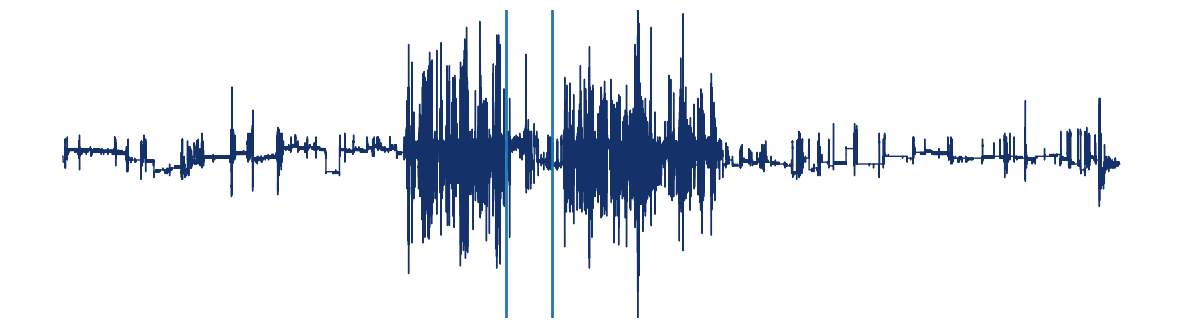

In [62]:
plt.figure(figsize=(15, 4))
plt.plot(time, signal_x, color='#15316A', linewidth=1)
plt.axis('off')  # Removes all axes
plt.ylim(-5, 5)
plt.axvline(x=time[290000])
plt.axvline(x=time[320000])
plt.show()

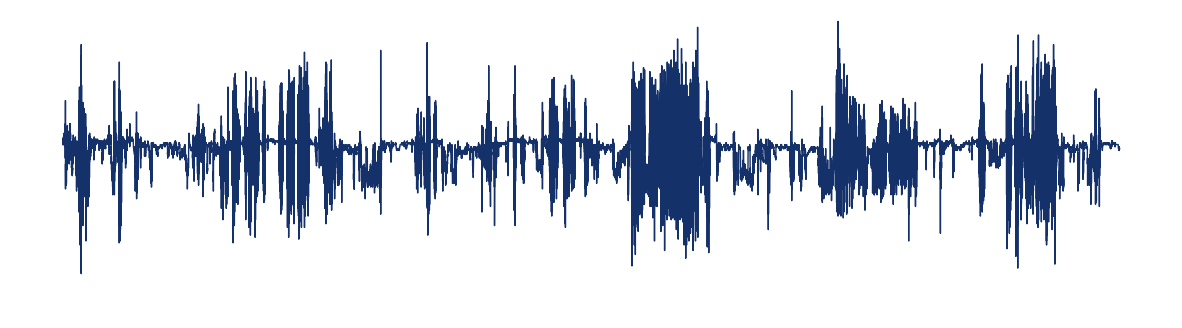

In [53]:
plt.figure(figsize=(15, 4))
plt.plot(time[225000:290000], signal_x[225000:290000], color='#15316A', linewidth=1)
plt.axis('off')  # Removes all axes
plt.ylim(-5, 5)
plt.show()

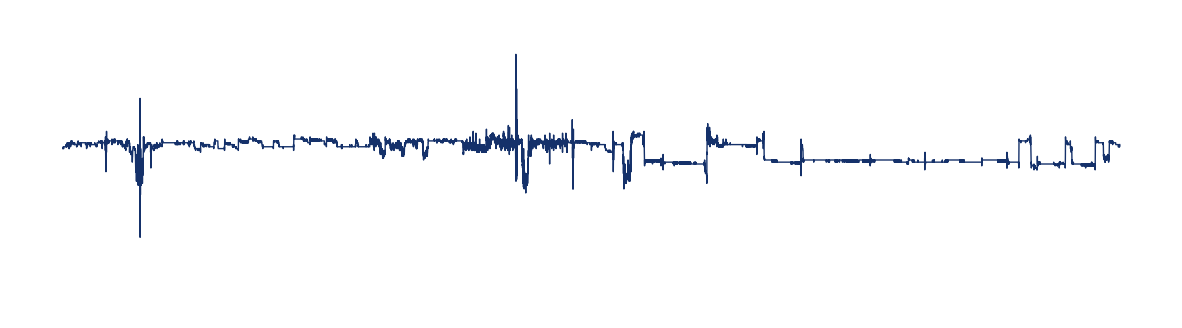

In [63]:
plt.figure(figsize=(15, 4))
plt.plot(time[290000:320000], signal_x[290000:320000], color='#15316A', linewidth=1)
plt.axis('off')  # Removes all axes
plt.ylim(-5, 5)
plt.show()

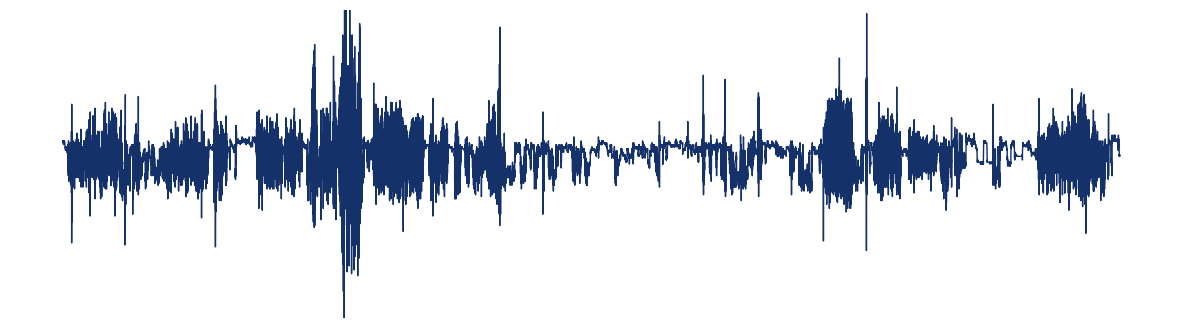

In [55]:
plt.figure(figsize=(15, 4))
plt.plot(time[360000:420000], signal_x[360000:420000], color='#15316A', linewidth=1)
plt.axis('off')  # Removes all axes
plt.ylim(-5, 5)
plt.show()